> **Best task comparison** \
> Comparison between TD3, SAC, and DSAC when controlling a LTI aircraft to track a sinusoidal pitch rate reference

# ⚙️ Set-up
Load required packages

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from helpers.paths import Path


from visualization.utils import make_smooth, make_defaults, save_pgf

# Setup defaults for plotting
make_defaults()

In [44]:
algo_order = ["SAC", "TD3", "DSAC"]
task_order = [f"TASK-{i}" for i in range(1,4)]

In [22]:
df_learn = pd.read_csv(Path.data/"Tasks_learning.csv")
df_ep = pd.read_csv(Path.data/"Tasks_episode.csv")

In [23]:
for _df_to_replace in [df_learn, df_ep]:
    _df_to_replace["task_type"].replace({
        "step_q": "TASK-1",
        "sin_q": "TASK-2",
        "square_q": r"TASK-3",
    }, inplace=True)

In [24]:
df_learn.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    45
SAC     45
TD3     45
dtype: int64

In [25]:
df_ep.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    45
SAC     45
TD3     45
dtype: int64

In [26]:
algorithm = "TD3"
df_ep_rew = df_ep.groupby(["run", "algorithm"])["reward"].sum().reset_index()
reward_count = df_ep_rew[df_ep_rew.algorithm==algorithm]["reward"].value_counts()
duplicated_rewards = reward_count[reward_count>1].index.values

df_ep_rew[df_ep_rew.reward.isin(duplicated_rewards)].groupby(["reward", "run"]).count()

,,algorithm
reward,run,


In [27]:
df_learn_smooth = make_smooth(df_learn, step=100, 
                              on="global_step", 
                              columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"],
                              info=["algorithm", "task_type"])

# 👨🏽‍🏫 Learning performance

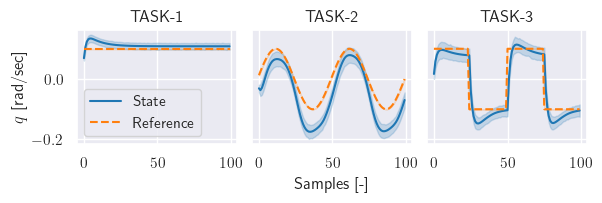

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2), sharey=True)

for idx, task in enumerate(task_order):
    f = sns.lineplot(data=df_ep[(df_ep.task_type == task) & (df_ep.algorithm == "DSAC")], x="episode_step", y="state", ax=ax[idx], legend=False, label="State")
    f.set(xlabel="");
    
    g = sns.lineplot(data=df_ep[df_ep.task_type == task], x="episode_step", y="reference", ax=ax[idx], legend=(idx==0), label="Reference", linestyle='--')
    g.set(xlabel="");
    
   
    
    ax[idx].set_title(task)

ax[0].set_ylabel(r"$q$ [rad/sec]")
ax[1].set_xlabel("Samples [-]")

save_pgf(fig, 'exp1_dsac_tracking.pgf', path="paper")

# sns.relplot(data=df_ep, x="episode_step", y="reference", col="task_type", kind="line")


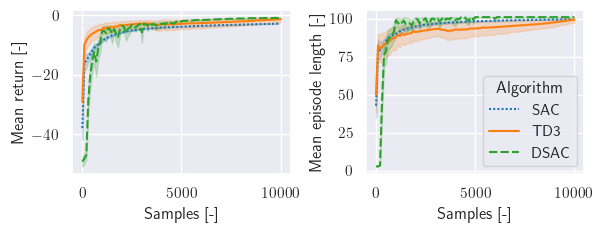

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2.3))
g = sns.lineplot(data=df_learn_smooth.rename(columns={"algorithm":"Algorithm"}), x="global_step", y="rollout/ep_rew_mean", hue="Algorithm", style="Algorithm", hue_order=algo_order, ax=ax[0], legend=False)
g.set(xlabel="Samples [-]", ylabel="Mean return [-]");

f = sns.lineplot(data=df_learn_smooth.rename(columns={"algorithm":"Algorithm"}), x="global_step", y="rollout/ep_len_mean", hue="Algorithm", style="Algorithm", hue_order=algo_order, ax=ax[1], legend=True)
f.set(xlabel="Samples [-]", ylabel="Mean episode length [-]");

fig.tight_layout(pad=.5)
fig.savefig(Path.figures/"test.pgf")

save_pgf(fig, 'exp1_performance.pgf', path="paper")

When averaging the performance of the algorithms learning three different tasks, SAC and TD3 Reach a higher return than DSAC. However, TD3 exhibits higher variance, especially int he length of episode. 

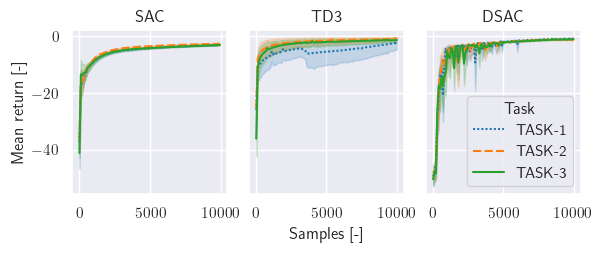

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2.5), sharey=True)

for idx, algo in enumerate(algo_order):
    
    g = sns.lineplot(data=df_learn_smooth[df_learn_smooth.algorithm == algo].rename(columns={"task_type":  "Task"}), x="global_step", y="rollout/ep_rew_mean", hue="Task", style="Task", hue_order=task_order, ax=ax[idx], legend=(idx==2))
    g.set(xlabel="");

    ax[idx].set_title(algo)

ax[0].set_ylabel("Mean return [-]")
ax[1].set_xlabel("Samples [-]")

save_pgf(fig, 'exp1_mean_return.pgf', path="paper")

# 📈 Episode analysis

In [68]:
df_ep_runs = df_ep.groupby(["run", "algorithm", "task_type"])["tracking_error"].sum().reset_index()

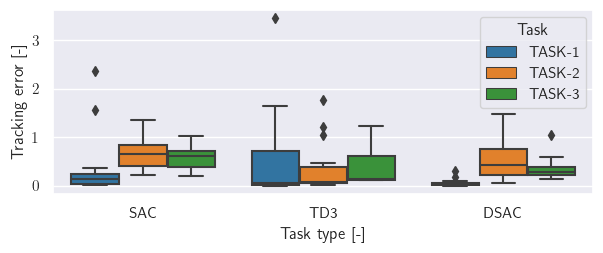

In [71]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.boxplot(data=df_ep_runs.rename(columns={"task_type": "Task"}), x="algorithm", y="tracking_error", hue="Task", order=algo_order, hue_order=task_order, ax=ax);
ax.set_xlabel("Task type [-]")
ax.set_ylabel("Tracking error [-]")

save_pgf(fig, 'exp1_episode_tracking.pgf', path="paper")

Task-1 shows to be the easier task for the three algorithms. TD3 can achive low tracking error, but wiht high variance. DSAC and DSAC show very similar behaviour in the evaluation, also the order of task they findmore diffioculkt.
